# Import Libraries
---

In [309]:
from pathlib import Path
import polars as pl 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import altair as alt
import yaml
from datetime import date
import numpy as np
from varname import nameof
import polars.selectors as cs

# Get YAML Config
---

In [310]:
with open('../config/cfg.yaml') as f:
    config = yaml.safe_load(f)

features = config['features']
target   = config["target"][0]
print(features)

['period_begin', 'period_end', 'region', 'state_code', 'median_sale_price', 'median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'new_listings', 'months_of_supply', 'median_dom', 'pending_sales', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks', 'median_sale_price_mom', 'median_sale_price_yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'homes_sold_mom', 'homes_sold_yoy', 'inventory_mom', 'inventory_yoy', 'median_dom_mom', 'median_dom_yoy', 'price_drops_mom', 'price_drops_yoy', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings_mom', 'new_listings_yoy', 'property_type']


# Set Constants
---

In [311]:
DATA_PATH         = Path("../data")
COUNTY_PATH       = DATA_PATH / "county_market_tracker.tsv000"
NEIGHBORHOOD_PATH = DATA_PATH / "neighborhood_market_tracker.tsv000"
STATE_PATH        = DATA_PATH / "state_market_tracker.tsv000"
US_NATION_PATH    = DATA_PATH / "us_national_market_tracker.tsv000"
ZIP_PATH          = DATA_PATH / "zip_code_market_tracker.tsv000"

# Data Information
---

In [312]:
county_df = pl.read_csv(COUNTY_PATH, separator="\t", columns=features).with_columns(
    pl.col("period_begin").cast(pl.Date()),
    pl.col("period_end").cast(pl.Date())
)
county_df.glimpse()

Rows: 563122
Columns: 34
$ period_begin            <date> 2017-04-01, 2014-12-01, 2018-02-01, 2017-08-01, 2019-05-01, 2017-06-01, 2019-12-01, 2018-06-01, 2018-07-01, 2014-11-01
$ period_end              <date> 2017-04-30, 2014-12-31, 2018-02-28, 2017-08-31, 2019-05-31, 2017-06-30, 2019-12-31, 2018-06-30, 2018-07-31, 2014-11-30
$ region                   <str> 'Morgan County, AL', 'Hennepin County, MN', 'Tulsa County, OK', 'Crow Wing County, MN', 'Tate County, MS', 'Walworth County, WI', 'Madison County, AL', 'Hamilton County, TX', 'Idaho County, ID', 'Guilford County, NC'
$ state_code               <str> 'AL', 'MN', 'OK', 'MN', 'MS', 'WI', 'AL', 'TX', 'ID', 'NC'
$ property_type            <str> 'All Residential', 'Multi-Family (2-4 Unit)', 'All Residential', 'Condo/Co-op', 'Single Family Residential', 'Single Family Residential', 'Multi-Family (2-4 Unit)', 'Single Family Residential', 'Single Family Residential', 'Condo/Co-op'
$ median_sale_price        <f64> 120500.0, 203000.0, 167500

In [313]:
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,685,52383,69332,43920,7395,679,52377,69325,79883,125130,142945,44898,82938,99747,22906,66101,84719,14964,58355,76113,8797,60417,77922,7931,5520,237761,264795,300991,66963


In [314]:
county_df.describe()

statistic,period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""563122""","""563122""","""563122""","""563122""","""563122""",562437.0,510739.0,493790.0,519202.0,555727.0,562443.0,510745.0,493797.0,483239.0,437992.0,420177.0,518224.0,480184.0,463375.0,540216.0,497021.0,478403.0,548158.0,504767.0,487009.0,554325.0,502705.0,485200.0,555191.0,557602.0,325361.0,298327.0,262131.0,496159.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",685.0,52383.0,69332.0,43920.0,7395.0,679.0,52377.0,69325.0,79883.0,125130.0,142945.0,44898.0,82938.0,99747.0,22906.0,66101.0,84719.0,14964.0,58355.0,76113.0,8797.0,60417.0,77922.0,7931.0,5520.0,237761.0,264795.0,300991.0,66963.0
"""mean""","""2017-03-14 16:01:17.073174""","""2017-04-13 02:47:53.468981""",null,null,null,204856.654317,1.167698,1.935374,232030.213737,1928.200556,121.35341,0.150434,0.347846,108.167373,0.167598,0.436182,154.916991,0.172941,0.259994,421.794199,0.009573,0.16447,5.701756,-0.138046,-0.988874,109.74947,-1.091533,-12.360146,0.959902,0.172628,0.200533,0.001515,0.004358,0.258053
"""std""",null,null,null,null,null,1.5061e6,388.591865,512.005735,1.9693e6,1.3414e6,347.492394,1.050092,3.983469,320.6543,1.254917,3.996148,430.174966,9.081662,7.013485,1118.946608,1.598657,8.601857,6.403006,7.539451,10.444344,195.650664,190.736681,202.129677,0.052256,0.192663,0.12395,0.092652,0.103921,0.249914
"""min""","""2012-01-01""","""2012-01-31""","""Abbeville County, SC""","""AK""","""All Residential""",1.0,-0.999996,-0.999994,100.0,0.00036,1.0,-0.972603,-0.988889,1.0,-0.9875,-0.982143,1.0,-0.995543,-0.994444,1.0,-0.959459,-0.992453,0.0,-1548.4,-1550.2,1.0,-8754.0,-15618.0,0.5,0.0,0.000058,-0.916667,-0.990566,0.0
"""25%""","""2014-10-01""","""2014-10-31""",null,null,null,115000.0,-0.096043,-0.043404,139900.0,71.743697,4.0,-0.195238,-0.117647,4.0,-0.2,-0.090909,7.0,-0.214286,-0.148148,21.0,-0.074286,-0.228049,2.5,-1.0,-2.0,41.0,-18.0,-32.0,0.942682,0.0,0.125926,-0.036976,-0.038988,0.0
"""50%""","""2017-05-01""","""2017-05-31""",null,null,null,163750.0,0.006536,0.075832,189900.0,99.027947,18.0,0.0,0.046218,15.0,0.0,0.105263,27.0,0.0,0.017544,85.0,-0.002326,-0.073892,4.2,0.0,-0.6,72.0,0.0,-7.0,0.968054,0.134021,0.183386,0.001292,0.001951,0.217391
"""75%""","""2019-09-01""","""2019-09-30""",null,null,null,238500.0,0.121857,0.221212,269950.0,136.258661,80.0,0.25,0.333333,68.0,0.285714,0.481481,110.0,0.269697,0.262295,331.0,0.055556,0.086849,7.0,0.9,0.5,120.0,16.0,12.0,0.986673,0.25,0.25,0.038642,0.043651,0.415385
"""max""","""2021-12-01""","""2021-12-31""","""Zavala County, TX""","""WV""","""Townhouse""",9.99999999e8,189999.0,220999.0,9.99999998e8,9.99999999e8,9186.0,250.0,696.0,8218.0,282.5,973.0,9899.0,4222.0,4222.0,26655.0,539.0,976.0,874.0,543.5,862.0,15811.0,15749.0,15774.0,1.963048,1.0,1.0,0.923077,0.954545,1.5


In [315]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,null,null,null,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,null,209900.0,147.076613,3,2.0,null,null,null,null,3,null,null,5,0.25,null,1.7,-2.3,null,107,-5,null,0.964538,0.0,0.2,-0.05,null,null
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,null,null,null,0.0


In [316]:
county_df = county_df.fill_null(strategy="mean")
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [317]:
county_df.sort("period_begin").group_by("period_begin").agg(pl.col("median_sale_price").mean()).plot.line(
    x="period_begin",
    y="median_sale_price"
).properties(
    width=700,
    height=500
).interactive()

alt.Chart(...)

In [318]:
county_df.filter(
    pl.col("period_begin").dt.year() == 2020
).sort("period_begin").group_by(pl.col("period_begin")).agg(pl.col(target).mean()).sort(target, descending=True)

period_begin,median_sale_price
date,f64
2020-08-01,443955.725739
2020-09-01,353603.636927
2020-10-01,260976.136142
2020-12-01,258914.736523
2020-11-01,257434.639791
…,…
2020-06-01,237098.737916
2020-05-01,236320.307852
2020-03-01,235490.922101


In [319]:
county_df.filter(
    pl.col("period_begin") == date(2020, 8, 1)
).sort(target, descending=True).head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Townhouse""",5.5e6,1.167698,1.935374,1.175e6,1003.649635,1,0.150434,0.347846,108,0.167598,0.436182,1,0.172941,0.259994,15,0.009573,0.16447,15.0,-0.138046,-0.988874,178,-1,-12,1.0,0.0,0.133333,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""All Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,0.666667,1.5,16,-0.238095,1.0,47,-0.078431,-0.145455,11.8,5.4,2.6,73,-46,-17,0.971717,0.25,0.170213,-0.006258,-0.102515,0.066667
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""Single Family Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,1.5,1.5,16,-0.157895,1.0,46,-0.061224,-0.098039,11.5,5.4,3.0,73,-46,-17,0.971717,0.25,0.152174,0.009317,-0.102728,0.066667
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Single Family Residential""",3.25e6,-0.811594,-0.044118,1.175e6,938.009788,4,0.0,0.0,1,0.167598,-0.5,19,-0.095238,0.461538,102,0.120879,0.030303,25.5,2.7,0.7,338,-424,111,1.0,0.0,0.392157,0.01853,0.260844,1.0


- Very large outlier in ohio

## Handle Outliers


In [320]:
Q1 = county_df[target].quantile(0.25)
Q3 = county_df[target].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
outliers = county_df.filter(
    (pl.col(target) < np.abs(Q1 - 1.5*IQR)) |
    (pl.col(target) > np.abs(Q3 + 1.5*IQR))
)
outliers.sort(target, descending=True)

115000.0 238250.0 123250.0


period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-09-01,2020-09-30,"""Fayette County, OH""","""OH""","""Condo/Co-op""",5.0010e8,1.167698,1.935374,152200.0,40557.783138,2,0.150434,0.347846,1,0.167598,0.436182,1,0.172941,0.259994,1,0.009573,0.16447,0.5,-0.138046,-0.988874,1,-1,-12,1.0,0.0,1.0,0.001515,0.004358,1.0
2017-11-01,2017-11-30,"""New York County, NY""","""NY""","""Townhouse""",2.6375e7,1.167698,10.722222,232030.213737,1608.981965,2,0.150434,1.0,1,0.167598,0.436182,154,0.172941,0.259994,35,0.009573,-0.375,17.5,-0.138046,-38.5,176,-1,-1456,1.0,0.0,0.114286,0.001515,0.004358,0.0
2017-08-01,2017-08-31,"""New York County, NY""","""NY""","""Townhouse""",2.25e7,2.797468,0.574803,1.225e6,674.157303,2,1.0,0.0,108,0.167598,0.436182,3,0.0,0.5,32,0.032258,-0.567568,16.0,-15.0,-21.0,394,263,323,0.917827,0.0,0.125,-0.294355,0.004358,0.258053
2019-06-01,2019-06-30,"""New York County, NY""","""NY""","""Townhouse""",2.065e7,1.167698,1.56124,1.215e6,2560.714286,4,0.150434,0.0,2,0.167598,0.436182,5,0.172941,1.5,19,0.009573,-0.321429,4.8,-0.138046,-2.2,495,-1,-98,1.0,0.0,0.210526,0.001515,-0.110902,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2017-03-01,2017-03-31,"""Ashtabula County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999972,-0.999956,89900.0,0.000488,1,-0.5,-0.5,3,2.0,0.0,9,2.0,1.25,26,0.130435,0.083333,26.0,14.5,14.0,97,53,54,0.959902,0.0,0.153846,0.110368,-0.054487,0.0
2012-11-01,2012-11-30,"""Miami County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999987,-0.999986,110900.0,0.000371,1,-0.75,0.0,2,-0.5,1.0,4,0.0,0.333333,20,0.052632,-0.310345,20.0,15.2,-9.0,175,123,92,0.959902,0.0,0.200533,0.001515,0.004358,0.0
2018-04-01,2018-04-30,"""Andrew County, MO""","""MO""","""Townhouse""",1.0,1.167698,1.935374,232030.213737,0.00036,1,0.150434,0.347846,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,258,-1,-12,0.959902,0.0,0.200533,0.001515,0.004358,0.258053


In [321]:
county_df_clean = county_df.filter(
    (pl.col(target) >= np.abs(Q1 - 1.5*IQR)) &
    (pl.col(target) <= np.abs(Q3 + 1.5*IQR))
)
county_df_clean.sort(target)

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2021-12-01,2021-12-31,"""Cleveland County, OK""","""OK""","""Condo/Co-op""",69875.0,-0.240489,-0.177941,225000.0,77.624461,10,-0.090909,0.428571,8,-0.111111,1.666667,5,-0.166667,1.5,5,-0.444444,-0.545455,0.5,-0.3,-1.1,70,13,-11,0.971946,0.2,0.2,0.088889,0.018182,0.5
2014-03-01,2014-03-31,"""Manitowoc County, WI""","""WI""","""Multi-Family (2-4 Unit)""",69875.0,0.193934,-0.001786,99900.0,48.076923,4,0.0,-0.333333,3,0.167598,0.0,10,0.666667,0.428571,41,0.078947,0.242424,10.3,0.8,4.8,71,-91,-8,0.812312,0.0,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""Single Family Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,32,0.230769,-0.304348,175,-0.022346,-0.048913,6.3,-7.5,-1.4,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""All Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,34,0.259259,-0.276596,183,-0.02139,-0.071066,6.5,-7.9,-1.7,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2016-10-01,2016-10-31,"""Greene County, IA""","""IA""","""Single Family Residential""",69875.0,-0.653118,0.751253,70950.0,60.655382,7,2.5,0.4,4,3.0,1.0,4,-0.555556,0.0,34,-0.105263,0.36,4.9,-14.1,-0.1,97,41,-92,0.91223,0.0,0.200533,0.001515,0.004358,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-07-01,2016-07-31,"""Los Angeles County, CA""","""CA""","""Condo/Co-op""",423000.0,0.007143,0.065491,550000.0,393.87164,1098,-0.110931,-0.104405,1082,-0.064823,-0.052539,1527,0.031757,0.014618,2796,0.087515,0.046016,2.5,0.4,0.3,29,-3,0,0.999186,0.387978,0.187768,-0.009431,-0.041562,0.354898
2018-12-01,2018-12-31,"""Rockland County, NY""","""NY""","""All Residential""",423000.0,0.043157,0.044444,436000.0,220.883534,248,0.227723,-0.019763,142,-0.059603,0.314815,138,-0.389381,0.0,907,-0.154706,0.013408,3.7,-1.6,0.2,76,7,16,0.970493,0.149194,0.154355,-0.058133,0.045975,0.091549
2018-08-01,2018-08-31,"""Fauquier County, VA""","""VA""","""Single Family Residential""",423062.5,0.024364,0.092902,394500.0,175.661914,96,-0.067961,-0.172414,62,-0.205128,0.016393,111,-0.034783,-0.017699,376,0.050279,-0.109005,3.9,0.4,0.3,46,18,13,0.983716,0.125,0.335106,-0.002882,0.107618,0.322581


## ADFuller Method to detect if data is Stationary

In [322]:
county_sample = county_df_clean.select(
    pl.col(target)
).sample(
    n=100_000,
    seed=42
)
county_sample.shape

adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(county_sample)

if pvalue < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary and need to difference")

Series is stationary


In [323]:
county_df_clean.select(target).to_numpy()

array([[120500.],
       [203000.],
       [167500.],
       ...,
       [173990.],
       [170000.],
       [128000.]], shape=(484040, 1))

In [324]:
county_df_clean[:1000].select(["period_begin", target]).plot.line(
    x="period_begin",
    y=target
)

alt.Chart(...)

- No autocorrelation is a problem for ARIMA, it's probably because there are different property types and maybe different counties

In [325]:
property_types = county_df_clean.select('property_type').unique().to_numpy()

In [326]:
county_df_clean["property_type"].value_counts()

property_type,count
str,u32
"""Single Family Residential""",155420
"""All Residential""",156976
"""Condo/Co-op""",67234
"""Multi-Family (2-4 Unit)""",51250
"""Townhouse""",53160


In [327]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,0.200533,0.001515,0.004358,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,1.935374,209900.0,147.076613,3,2.0,0.347846,108,0.167598,0.436182,3,0.172941,0.259994,5,0.25,0.16447,1.7,-2.3,-0.988874,107,-5,-12,0.964538,0.0,0.2,-0.05,0.004358,0.258053
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,0.200533,0.001515,0.004358,0.0


In [328]:
county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC").group_by("property_type").agg(
    pl.col(target).mean().alias("target_mean"), 
    pl.col(target).std().alias("target_std"),
    pl.col(target).min().alias("target_min"),
    pl.col(target).max().alias("target_max"),
    pl.col(target).count().alias("target_count"),
).sort("target_mean")

property_type,target_mean,target_std,target_min,target_max,target_count
str,f64,f64,f64,f64,u32
"""Multi-Family (2-4 Unit)""",207834.182292,95285.762986,70000.0,409000.0,96
"""Condo/Co-op""",210126.023585,55706.236732,82750.0,342500.0,106
"""Townhouse""",229826.777174,70111.679809,70000.0,365250.0,92
"""All Residential""",245412.560748,53671.121975,166500.0,385000.0,107
"""Single Family Residential""",250932.504673,61491.787406,167500.0,405539.0,107


In [329]:
single_family   = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Single Family Residential")
multi_family    = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Multi-Family (2-4 Unit)")
condo_coop      = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Condo/Co-op")
townhouse       = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Townhouse")
all_residential = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "All Residential")

In [330]:
single_family_model = ARIMA(single_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
multi_family_model  = ARIMA(multi_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
condo_coop_model = ARIMA(condo_coop.select(target).to_numpy().flatten(), order=(1, 1, 1))
townhouse_model = ARIMA(townhouse.select(target).to_numpy().flatten(), order=(1, 1, 1))
all_residential_model = ARIMA(all_residential.select(target).to_numpy().flatten(), order=(1, 1, 1))

In [331]:
single_family_fit = single_family_model.fit()
multi_family_fit = multi_family_model.fit()
condo_coop_fit = condo_coop_model.fit()
townhouse_fit = townhouse_model.fit()
all_residential_fit = all_residential_model.fit()
all_fits = [single_family_fit, multi_family_fit, condo_coop_fit, townhouse_fit, all_residential_fit]

In [332]:
i = 1
for fit in all_fits:
    print(f"Fit {i}", "#"*50, sep="\n")
    print(fit.summary())
    print("\n")
    i += 1

Fit 1
##################################################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1322.004
Date:                Mon, 01 Dec 2025   AIC                           2650.008
Time:                        00:46:46   BIC                           2657.999
Sample:                             0   HQIC                          2653.247
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.126      0.054      0.957      -0.240       0.253
ma.L1         -0.9115      0.057    -16.116      0.000      -1.022      -0

In [333]:
condo_coop_forecast = condo_coop_fit.get_forecast(steps=12)
condo_coop_forecast_df = pl.from_pandas(condo_coop_forecast.summary_frame())

In [334]:
condo_coop_forecast_df

mean,mean_se,mean_ci_lower,mean_ci_upper
f64,f64,f64,f64
207656.325839,63154.382576,83876.010525,331436.641153
206541.722163,63189.708116,82692.170063,330391.274263
206521.794859,63197.313851,82657.335791,330386.253926
206521.438591,63204.594639,82642.709442,330400.16774
206521.432221,63211.86885,82628.44588,330414.418562
…,…,…,…
206521.432105,63233.686151,82585.684639,330457.179571
206521.432105,63240.956912,82571.434211,330471.43
206521.432105,63248.226836,82557.18542,330485.678791


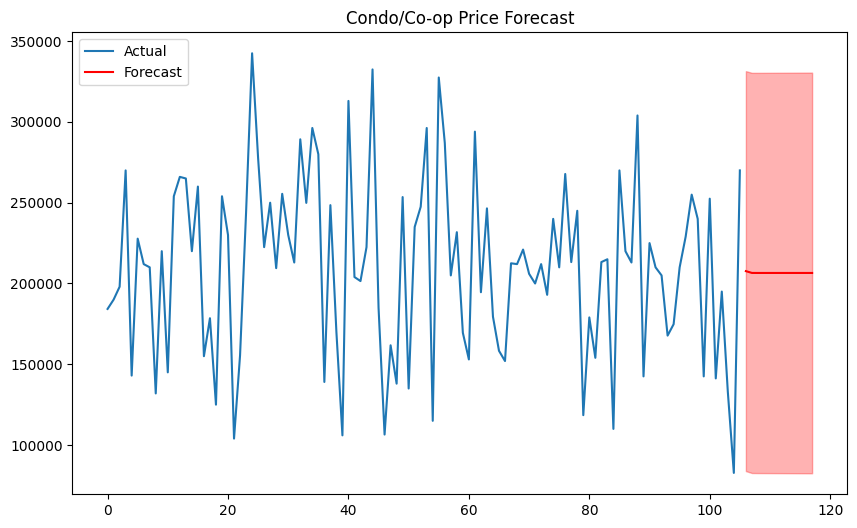

In [335]:
plt.plot(condo_coop[target],label="Actual")
plt.plot(range(len(condo_coop), len(condo_coop) + 12),
         condo_coop_forecast_df["mean"], label="Forecast", color="red"
)
plt.fill_between(range(len(condo_coop), len(condo_coop) + 12),
                 condo_coop_forecast_df["mean_ci_lower"], condo_coop_forecast_df["mean_ci_upper"],
                 alpha=0.3, color="red")

plt.legend()
plt.title("Condo/Co-op Price Forecast")
plt.show()

<Figure size 1500x700 with 0 Axes>

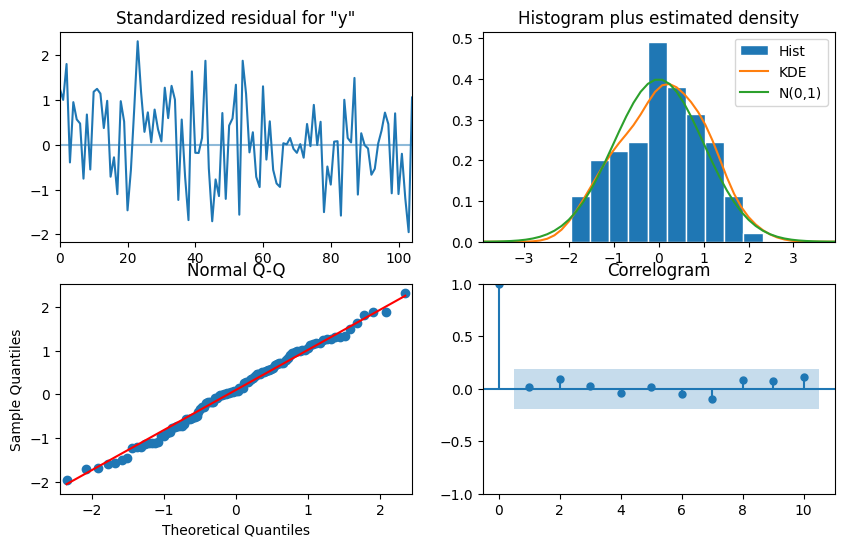

In [336]:
plt.figure(figsize=(15, 7))
condo_coop_fit.plot_diagnostics()
plt.show()

In [337]:
meck_data = county_df_clean.filter(
    pl.col("region") == "Mecklenburg County, NC"
).sort("period_begin")

In [338]:
meck_data.select("property_type").unique().to_numpy().flatten()

array(['Condo/Co-op', 'All Residential', 'Single Family Residential',
       'Multi-Family (2-4 Unit)', 'Townhouse'], dtype=object)

In [339]:
selection = alt.selection_point(fields=["property_type"], bind="legend")

alt.Chart(meck_data).mark_line().encode(
    x=alt.X('period_begin:T'),
    y=alt.Y(f'{target}:Q'),
    color=alt.Color('property_type:N', title='Property Type'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).properties(
    width=800,
    height=400,
    title="Mecklenburg County - All Property Types Median Sale Price"
).add_params(selection).interactive()

alt.Chart(...)

In [340]:
for col in meck_data.select(cs.float()).drop(["pending_sales_mom", "pending_sales_yoy"]).columns:
    adf_stat, p_val, *_ = adfuller(meck_data.select(col))
    print(f"{col}: {"Stationary" if p_val < 0.05 else "Non-stationary"} (p={p_val:.4f})")

median_sale_price: Non-stationary (p=0.9174)
median_sale_price_mom: Stationary (p=0.0000)
median_sale_price_yoy: Stationary (p=0.0268)
median_list_price: Non-stationary (p=0.8752)
median_ppsf: Non-stationary (p=0.9823)
homes_sold_mom: Stationary (p=0.0000)
homes_sold_yoy: Non-stationary (p=0.2773)
new_listings_mom: Stationary (p=0.0000)
new_listings_yoy: Non-stationary (p=0.1102)
inventory_mom: Stationary (p=0.0000)
inventory_yoy: Non-stationary (p=0.8243)
months_of_supply: Non-stationary (p=0.1642)
months_of_supply_mom: Stationary (p=0.0000)
months_of_supply_yoy: Stationary (p=0.0000)
avg_sale_to_list: Stationary (p=0.0011)
sold_above_list: Non-stationary (p=0.2323)
price_drops: Stationary (p=0.0001)
price_drops_mom: Stationary (p=0.0000)
price_drops_yoy: Stationary (p=0.0017)
off_market_in_two_weeks: Stationary (p=0.0428)


In [341]:
model = ARIMA(meck_data.select(target).to_numpy(), order=(1, 1, 1))
results = model.fit()

In [342]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6187.521
Date:                Mon, 01 Dec 2025   AIC                          12381.042
Time:                        00:46:46   BIC                          12393.727
Sample:                             0   HQIC                         12386.016
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0509      0.060     -0.847      0.397      -0.169       0.067
ma.L1         -0.9269      0.023    -40.465      0.000      -0.972      -0.882
sigma2      2.816e+09   6.89e-13   4.09e+21      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.71   Prob(JB):                         0.41
Heteroskedasticity (H):               1.00   Skew:                            -0.09
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+37. Standard errors may be unstable.
"""

In [343]:
model = ARIMA(meck_data.select(target).to_numpy(), order=(0, 1, 1))
results = model.fit()

In [344]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6188.103
Date:                Mon, 01 Dec 2025   AIC                          12380.206
Time:                        00:46:46   BIC                          12388.663
Sample:                             0   HQIC                         12383.523
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9317      0.021    -45.349      0.000      -0.972      -0.891
sigma2      2.822e+09    8.1e-14   3.48e+22      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.16   Prob(JB):                         0.41
Heteroskedasticity (H):               1.01   Skew:                            -0.09
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

# Deep Learning
---

In [509]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import ToTensor
from featurewiz_polars import FeatureWiz
from abc import ABC, abstractmethod
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import random
from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [346]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device

'cuda'

In [397]:
TSA_TRAIN = DATA_PATH / "processed/tsa_train.csv"
TSA_TEST  = DATA_PATH / "processed/tsa_test.csv" 

In [398]:
cols_to_drop = ["period_begin", "period_end", "state_code", "quarter_label", "year_quarter", "market_phase"]

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0, add_batch_norm: bool=False):
        super(GRU, self).__init__()
        self.m_hidden_size = hidden_size
        self.m_num_layers  = num_layers
        self.m_add_batch_norm = add_batch_norm

        # gru layers
        self.m_gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # fully connected output layer
        self.m_fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # init hidden state
        h0 = torch.zeros(self.m_num_layers, x.size(0), self.m_hidden_size).to(device=x.device)

        # forward prop
        gru_out, _ = self.m_gru(x, h0)

        if self.m_add_batch_norm:
            batch_out = nn.BatchNorm1d(gru_out.view(-1, gru_out.size(-1)))
            batch_out = batch_out.view(gru_out.size(0), gru_out.size(1), -1)
            last_time_step_out = self.m_fc(batch_out[:, -1, :])
        else:
            last_time_step_out = self.m_fc(gru_out[:, -1, :])
            
        return last_time_step_out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int, dropout=0.0, add_batch_norm: bool=False):
        super(LSTM, self).__init__()
        self.m_hidden_size = hidden_size
        self.m_num_layers = num_layers
        
        self.m_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.m_fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.m_num_layers, x.size(0), self.m_hidden_size).to(x.device)
        c0 = torch.zeros(self.m_num_layers, x.size(0), self.m_hidden_size).to(x.device)
        
        out, _ = self.m_lstm(x, (h0, c0))
        out = self.m_fc(out[:, -1, :])
        return out

In [547]:
class Optimize:
    def __init__(self, model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, scaler_x=None, scaler_y=None,  device:str="cuda", lr: float=1e-3, weight_decay: float=0.0):
        
        self.m_model  = model
        self.m_train_dataloader = train_dataloader
        self.m_test_dataloader = test_dataloader
        self.m_lr     = lr
        self.m_cploss = nn.MSELoss()
        self.m_weight_decay = weight_decay
        self.m_optim  = torch.optim.Adam(self.m_model.parameters(), lr=self.m_lr, weight_decay=self.m_weight_decay)
        self.m_device = device
        self.m_model.to(self.m_device)
        self.m_scaler_x = scaler_x
        self.m_scaler_y = scaler_y

        self.m_train_losses = []
        self.m_test_losses  = []

        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.m_optim, mode='min', factor=0.5, patience=7
        )

    @staticmethod
    def set_seed(seed=42):
        # seed
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @staticmethod
    def split_data(data: pl.DataFrame, target: str, lookback: int=12):
        features = data.drop(target)

        X, y = [], []
        for i in range(len(features) - lookback):
            X.append(features[i:i+lookback])
            y.append(features[i+lookback, 0])
        
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)

        return X, y
    
    @staticmethod
    def preprocess_data(X_train, X_test, y_train, y_test):
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        n_samples, n_timesteps, n_features = X_train.shape
        
        X_train_2d = X_train.reshape(-1, n_features)
        X_train_scaled_2d = scaler_x.fit_transform(X_train_2d)
        X_train_scaled = X_train_scaled_2d.reshape(n_samples, n_timesteps, n_features)
        
        X_test_2d = X_test.reshape(-1, n_features)
        X_test_scaled_2d = scaler_x.transform(X_test_2d)
        X_test_scaled = X_test_scaled_2d.reshape(X_test.shape[0], n_timesteps, n_features)

        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
        
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_x, scaler_y

    def train(self):
        size = len(self.m_train_dataloader.dataset)
        self.m_model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(self.m_train_dataloader):
            X, y = X.to(self.m_device), y.to(self.m_device)

            # compute prediction error/forward pass
            pred = self.m_model(X)
            loss = self.m_cploss(pred, y)

            # backprop
            self.m_optim.zero_grad()
            loss.backward()
            self.m_optim.step()

            train_loss += loss.item()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

        avg_train_loss = train_loss / len(self.m_train_dataloader)
        self.m_train_losses.append(avg_train_loss)
        return avg_train_loss

    def test(self):
        size = len(self.m_test_dataloader.dataset)
        num_batches = len(self.m_test_dataloader)
        self.m_model.eval()
        test_loss = 0
        
        with torch.no_grad():
            for X, y in self.m_test_dataloader:
                X, y = X.to(self.m_device), y.to(self.m_device)
                pred = self.m_model(X)
                test_loss += self.m_cploss(pred, y).item()
        
        test_loss /= num_batches
        self.m_test_losses.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f}\n")
        return test_loss

    def fit(self, epochs: int=5, patience: int=15, verbose: bool=True):
        # for t in range(epochs):
        #     print(f"Epoch {t+1}\n-----------------------")
        #     self.train()
        #     self.test()
        # print("Done")
        best_test_loss = float("inf")
        best_model_state = None
        patience_counter = 0
        prev_lr = self.m_optim.param_groups[0]["lr"]

        for epoch in range(epochs):
            train_loss = self.train()
            test_loss  = self.test()

            # update learning rate
            self.scheduler.step(test_loss)
            current_lr = self.m_optim.param_groups[0]['lr']

            # check if learning rate changed
            if current_lr != prev_lr:
                print(f"\n Learning Rate reduced: {prev_lr:.6f} -> {current_lr:.6f}")
                prev_lr = current_lr
            
            # logging
            if verbose and (epoch + 1) % 10 == 0:
                print(f"\nEpoch {epoch+1}/{epochs}")
                print(f"  Train Loss: {train_loss:.6f}")
                print(f"  Test Loss:  {test_loss:.6f}")
                print(f"  LR:         {current_lr:.6f}")

            # early stopping
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = self.m_model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"\n Early stopping triggered at epoch {epoch+1}.")
                break

        if best_model_state is not None:
            self.m_model.load_state_dict(best_model_state)
            print(f"\n Training complete! Loaded best model.")

        print(f"Total epochs: {epoch+1}")
        print(f"Best test loss: {best_test_loss:.6f}")

    def make_predictions(self, return_original_scale=True):
        self.m_model.eval()
        predictions_scaled = []
        actuals_scaled     = []
        
        with torch.no_grad():
            for X, y in self.m_test_dataloader:
                X = X.to(self.m_device)
                pred = self.m_model(X)
                predictions_scaled.append(pred.cpu().numpy())
                actuals_scaled.append(y.numpy())


        print(f"\nNumber of batches: {len(predictions_scaled)}")
        print(f"Shapes in list:")
        # for i, (p, a) in enumerate(zip(predictions_scaled, actuals_scaled)):
        #     print(f"  Batch {i}: pred {p.shape}, actual {a.shape}")

        try:
            predictions_scaled = np.concatenate(predictions_scaled, axis=0)
            print("predictions: success")
        except Exception as e:
            print(f"predictions: failed -> {e}")

        try:
            actuals_scaled = np.concatenate(actuals_scaled, axis=0)
            print("actuals: success")
        except Exception as e:
            print(f"actuals: failed -> {e}")

        if return_original_scale and self.m_scaler_y is not None:
            predictions_original = self.m_scaler_y.inverse_transform(predictions_scaled)
            actuals_original     = self.m_scaler_y.inverse_transform(actuals_scaled)
            return predictions_original, actuals_original
        else:
            return predictions_scaled, actuals_scaled
    
    def evaluate(self):
        """Evaluate model with metrics and overfitting analysis"""
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        
        # Get test predictions
        test_predictions, test_actuals = self.make_predictions(return_original_scale=True)
        
        # Get train predictions
        self.m_model.eval()
        train_preds, train_acts = [], []
        with torch.no_grad():
            for X, y in self.m_train_dataloader:
                X = X.to(self.m_device)
                pred = self.m_model(X)
                train_preds.append(pred.cpu().numpy())
                train_acts.append(y.numpy())
        
        train_preds = np.concatenate(train_preds, axis=0)
        train_acts = np.concatenate(train_acts, axis=0)
        
        # Inverse transform train predictions
        if self.m_scaler_y is not None:
            train_preds = self.m_scaler_y.inverse_transform(train_preds)
            train_acts = self.m_scaler_y.inverse_transform(train_acts)
        
        # Calculate metrics for both train and test
        r2_train = r2_score(train_acts, train_preds)
        r2_test = r2_score(test_actuals, test_predictions)
        r2_gap = r2_train - r2_test
        
        rmse_train = np.sqrt(mean_squared_error(train_acts, train_preds))
        rmse_test = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        
        mae_test = mean_absolute_error(test_actuals, test_predictions)
        mape_test = np.mean(np.abs((test_actuals - test_predictions) / test_actuals)) * 100
        
        # Loss ratio
        train_loss_final = self.m_train_losses[-1]
        test_loss_final = self.m_test_losses[-1]
        loss_ratio = test_loss_final / train_loss_final
        
        # Print results
        print(f"\n{'='*60}")
        print(f"MODEL EVALUATION")
        print(f"{'='*60}")
        
        print(f"\nTest Set Performance:")
        print(f"   R²:    {r2_test:.4f}")
        print(f"   RMSE:  {rmse_test:,.4f}")
        print(f"   MAE:   {mae_test:,.4f}")
        print(f"   MAPE:  {mape_test:.2f}%")
        
        print(f"\nTrain vs Test Comparison:")
        print(f"   Train R²:       {r2_train:.4f}")
        print(f"   Test R²:        {r2_test:.4f}")
        print(f"   R² Gap:         {r2_gap:.4f}")
        print(f"   ")
        print(f"   Train RMSE:     ${rmse_train:,.2f}")
        print(f"   Test RMSE:      ${rmse_test:,.2f}")
        print(f"   ")
        print(f"   Train Loss:     {train_loss_final:.6f}")
        print(f"   Test Loss:      {test_loss_final:.6f}")
        print(f"   Loss Ratio:     {loss_ratio:.2f}")
        
        # overfitting analysis
        print(f"\nOverfitting Check:")
        
        is_overfitting = False
        
        # check R² gap
        if r2_gap > 0.15:
            print(f"   Large R² gap ({r2_gap:.4f}) - OVERFITTING")
            is_overfitting = True
        elif r2_gap > 0.05:
            print(f"   Moderate R² gap ({r2_gap:.4f}) - Slight overfitting")
        else:
            print(f"   Small R² gap ({r2_gap:.4f}) - Good generalization")
        
        # check loss ratio
        if loss_ratio > 2.0:
            print(f"   High loss ratio ({loss_ratio:.2f}) - OVERFITTING")
            is_overfitting = True
        elif loss_ratio > 1.5:
            print(f"   Moderate loss ratio ({loss_ratio:.2f}) - Slight overfitting")
        else:
            print(f"   Good loss ratio ({loss_ratio:.2f})")
        
        # check if test loss increased during training
        if len(self.m_test_losses) > 5:
            min_test_loss_idx = np.argmin(self.m_test_losses)
            min_test_loss = self.m_test_losses[min_test_loss_idx]
            
            if test_loss_final > min_test_loss * 1.1:
                print(f"   Test loss increased after epoch {min_test_loss_idx + 1}")
            else:
                print(f"   Test loss stable (best at epoch {min_test_loss_idx + 1})")
        
        if is_overfitting:
            print(f"\nRecommendations to reduce overfitting:")
            print(f"   • Add dropout (0.2-0.3)")
            print(f"   • Reduce model size (fewer layers/units)")
            print(f"   • Use early stopping")
            print(f"   • Get more training data")
        elif r2_gap > 0.05 or loss_ratio > 1.5:
            print(f"\nRecommendations:")
            print(f"   • Consider light regularization")
            print(f"   • Early stopping might help")
        else:
            print(f"\nModel is generalizing well!")
            print(f"   • Can try increasing capacity for better performance")
        
        print(f"{'='*60}")
        
        return {
            'r2_test': r2_test,
            'r2_train': r2_train,
            'r2_gap': r2_gap,
            'rmse_test': rmse_test,
            'rmse_train': rmse_train,
            'mae': mae_test,
            'mape': mape_test,
            'loss_ratio': loss_ratio,
            'is_overfitting': is_overfitting,
            'predictions': test_predictions,
            'actuals': test_actuals
        }

In [ ]:
class ArchSearch():
    def __init__(self, train_dataloader: DataLoader, test_dataloader: DataLoader, epochs: int=100, scaler_x: MinMaxScaler=None, scaler_y: MinMaxScaler=None, model: str="GRU", input_size: int=None, dropout: float=0.0):
        self.m_configs = [
            {'hidden': 32, 'layers': 1},
            {'hidden': 64, 'layers': 1},
            {'hidden': 64, 'layers': 2},
            {'hidden': 128, 'layers': 2},
            {'hidden': 128, 'layers': 3},
            {'hidden': 256, 'layers': 2},
        ]
        
        self.m_epochs = epochs
        self.m_train_dataloader = train_dataloader
        self.m_test_dataloader  = test_dataloader
        self.m_input_size = self.m_train_dataloader.dataset[0][0].shape[1]
        self.m_dropout = dropout
        self.m_model_name = model 
        self.m_model: nn.Module = GRU if self.m_model_name=="GRU" else LSTM
        self.m_scaler_x = scaler_x
        self.m_scaler_y = scaler_y

        self.m_arch_results = []

    def run(self):
        for config in self.m_configs:
            print(f"\n Testing h={config['hidden']}, l={config["layers"]}")
        
            model = self.m_model(
                input_size=1 if self.m_input_size==0 else self.m_input_size,
                hidden_size=config["hidden"],
                num_layers=config["layers"],
                output_size=1,
                dropout=self.m_dropout
            )

            optimizer = Optimize(model, self.m_train_dataloader, self.m_test_dataloader, self.m_scaler_x, self.m_scaler_y, lr=0.0001)

            for epoch in range(self.m_epochs):
                print(f"Epoch #: {epoch}")
                optimizer.train()
                optimizer.test()

            predictions, actuals = optimizer.make_predictions()
            r2 = r2_score(actuals, predictions)
            
            self.m_arch_results.append({**config, 'r2':r2})
            print(f"R2: {r2:.4f}")
        best_arch = max(self.m_arch_results, key=lambda x: x['r2'])
        print(f"\n Best architecture: {best_arch}")
        return model

In [442]:
tsa_train_df = pl.read_csv(TSA_TRAIN).drop(cols_to_drop).drop_nulls()
tsa_test_df  = pl.read_csv(TSA_TEST).drop(cols_to_drop).drop_nulls()
tsa_train_X, tsa_train_y = Optimize.split_data(tsa_train_df, target)
tsa_test_X, tsa_test_y   = Optimize.split_data(tsa_test_df, target)
tsa_X_train_scaled, tsa_X_test_scaled, tsa_y_train_scaled, tsa_y_test_scaled, scaler_x, scaler_y = Optimize.preprocess_data(tsa_train_X, tsa_test_X, tsa_train_y, tsa_test_y)
train_dataset = TensorDataset(torch.FloatTensor(tsa_X_train_scaled), torch.FloatTensor(tsa_y_train_scaled))
test_dataset  = TensorDataset(torch.FloatTensor(tsa_X_test_scaled), torch.FloatTensor(tsa_y_test_scaled))

In [443]:
input_size  = tsa_train_df.shape[1] - 1
batch_size  = 64
hidden_size = 64
num_layers  = 2
output_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([64, 12, 20])
Shape of y: torch.Size([64, 1]) torch.float32


In [ ]:
Optimize.set_seed()
arch_search = ArchSearch(train_dataloader, test_dataloader, model="GRU", scaler_x=scaler_x, scaler_y=scaler_y, epochs=50)
arch_search_gru_model = arch_search.run()

In [463]:
torch.save(arch_search_gru_model.state_dict(), "../models/arch_search_gru_model.pth")

In [548]:
Optimize.set_seed(41)
gru = GRU(input_size=20, hidden_size=64, num_layers=2, output_size=output_size, dropout=0.4)
optim = Optimize(gru, train_dataloader, test_dataloader, scaler_x, scaler_y, device, 0.001, weight_decay=1e-5)
optim.fit(epochs=150, patience=30, verbose=True)

loss: 0.007641 [   64/ 9078]
loss: 0.000563 [ 6464/ 9078]
Test Error: Avg loss: 0.245192

loss: 0.866097 [   64/ 9078]
loss: 0.000402 [ 6464/ 9078]
Test Error: Avg loss: 0.386778

loss: 1.036706 [   64/ 9078]
loss: 0.000447 [ 6464/ 9078]
Test Error: Avg loss: 0.328621

loss: 0.931643 [   64/ 9078]
loss: 0.000311 [ 6464/ 9078]
Test Error: Avg loss: 0.214315

loss: 0.697346 [   64/ 9078]
loss: 0.000337 [ 6464/ 9078]
Test Error: Avg loss: 0.196088

loss: 0.653361 [   64/ 9078]
loss: 0.000230 [ 6464/ 9078]
Test Error: Avg loss: 0.194110

loss: 0.632524 [   64/ 9078]
loss: 0.000189 [ 6464/ 9078]
Test Error: Avg loss: 0.262879

loss: 0.729157 [   64/ 9078]
loss: 0.000218 [ 6464/ 9078]
Test Error: Avg loss: 0.241162

loss: 0.691505 [   64/ 9078]
loss: 0.000184 [ 6464/ 9078]
Test Error: Avg loss: 0.265968

loss: 0.700934 [   64/ 9078]
loss: 0.000318 [ 6464/ 9078]
Test Error: Avg loss: 0.288770


Epoch 10/150
  Train Loss: 0.024445
  Test Loss:  0.288770
  LR:         0.001000
loss: 0.712825 [ 

In [549]:
predictions_original, actuals_original = optim.make_predictions()


Number of batches: 38
Shapes in list:
predictions: success
actuals: success


In [550]:
results = optim.evaluate()


Number of batches: 38
Shapes in list:
predictions: success
actuals: success

MODEL EVALUATION

Test Set Performance:
   R²:    0.9952
   RMSE:  42.1761
   MAE:   24.8970
   MAPE:  0.09%

Train vs Test Comparison:
   Train R²:       0.9979
   Test R²:        0.9952
   R² Gap:         0.0027
   
   Train RMSE:     $27.96
   Test RMSE:      $42.18
   
   Train Loss:     0.000173
   Test Loss:      0.000238
   Loss Ratio:     1.38

Overfitting Check:
   Small R² gap (0.0027) - Good generalization
   Good loss ratio (1.38)
   Test loss increased after epoch 80

Model is generalizing well!
   • Can try increasing capacity for better performance


In [419]:
torch.save(gru.state_dict(), "../models/gru_3")

In [421]:
lstm = LSTM(input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, dropout=0)
optim = Optimize(lstm, train_dataloader, test_dataloader, scaler_x, scaler_y, device, 0.0001)
optim.fit(epochs=100, patience=30, verbose=True)

loss: 0.004008 [   64/ 9078]
loss: 0.000862 [ 6464/ 9078]
Test Error: Avg loss: 0.607352


 Training complete! Loaded best model.
Total epochs: 1
Best test loss: 0.607352
loss: 1.272975 [   64/ 9078]
loss: 0.001368 [ 6464/ 9078]
Test Error: Avg loss: 0.156568


 Training complete! Loaded best model.
Total epochs: 2
Best test loss: 0.156568
loss: 0.555298 [   64/ 9078]
loss: 0.001194 [ 6464/ 9078]
Test Error: Avg loss: 0.131024


 Training complete! Loaded best model.
Total epochs: 3
Best test loss: 0.131024
loss: 0.488040 [   64/ 9078]
loss: 0.000958 [ 6464/ 9078]
Test Error: Avg loss: 0.113826


 Training complete! Loaded best model.
Total epochs: 4
Best test loss: 0.113826
loss: 0.427729 [   64/ 9078]
loss: 0.000573 [ 6464/ 9078]
Test Error: Avg loss: 0.076207


 Training complete! Loaded best model.
Total epochs: 5
Best test loss: 0.076207
loss: 0.326813 [   64/ 9078]
loss: 0.000317 [ 6464/ 9078]
Test Error: Avg loss: 0.028749


 Training complete! Loaded best model.
Total epochs: 6

In [551]:
predictions_original, actuals_original = optim.make_predictions()


Number of batches: 38
Shapes in list:
predictions: success
actuals: success


In [552]:
results = optim.evaluate()


Number of batches: 38
Shapes in list:
predictions: success
actuals: success

MODEL EVALUATION

Test Set Performance:
   R²:    0.9952
   RMSE:  42.1761
   MAE:   24.8970
   MAPE:  0.09%

Train vs Test Comparison:
   Train R²:       0.9979
   Test R²:        0.9952
   R² Gap:         0.0027
   
   Train RMSE:     $27.96
   Test RMSE:      $42.18
   
   Train Loss:     0.000173
   Test Loss:      0.000238
   Loss Ratio:     1.38

Overfitting Check:
   Small R² gap (0.0027) - Good generalization
   Good loss ratio (1.38)
   Test loss increased after epoch 80

Model is generalizing well!
   • Can try increasing capacity for better performance


In [554]:
torch.save(optim.m_model.state_dict(), "../models/gru_model_r2_0995.pt")

In [555]:
model_config = {
    'model_type': 'GRU',
    'input_size': 1,
    'hidden_size': 64,  
    'num_layers': 2,    
    'dropout': 0.4,  
    'weight_decay': 1e-5,   
    'lookback': 12,     
    'test_r2': 0.9952,
    'test_rmse': 42.18,
    'mape': 0.09,
    'loss_ratio': 1.38,
    'best_epoch': 80
}

In [557]:
import json
with open("../config/best_gru_model_config.json", 'w') as f:
    json.dump(model_config, f, indent=2)

FileNotFoundError: [Errno 2] No such file or directory: '../images/gru_housing_results_r2_0995.png'

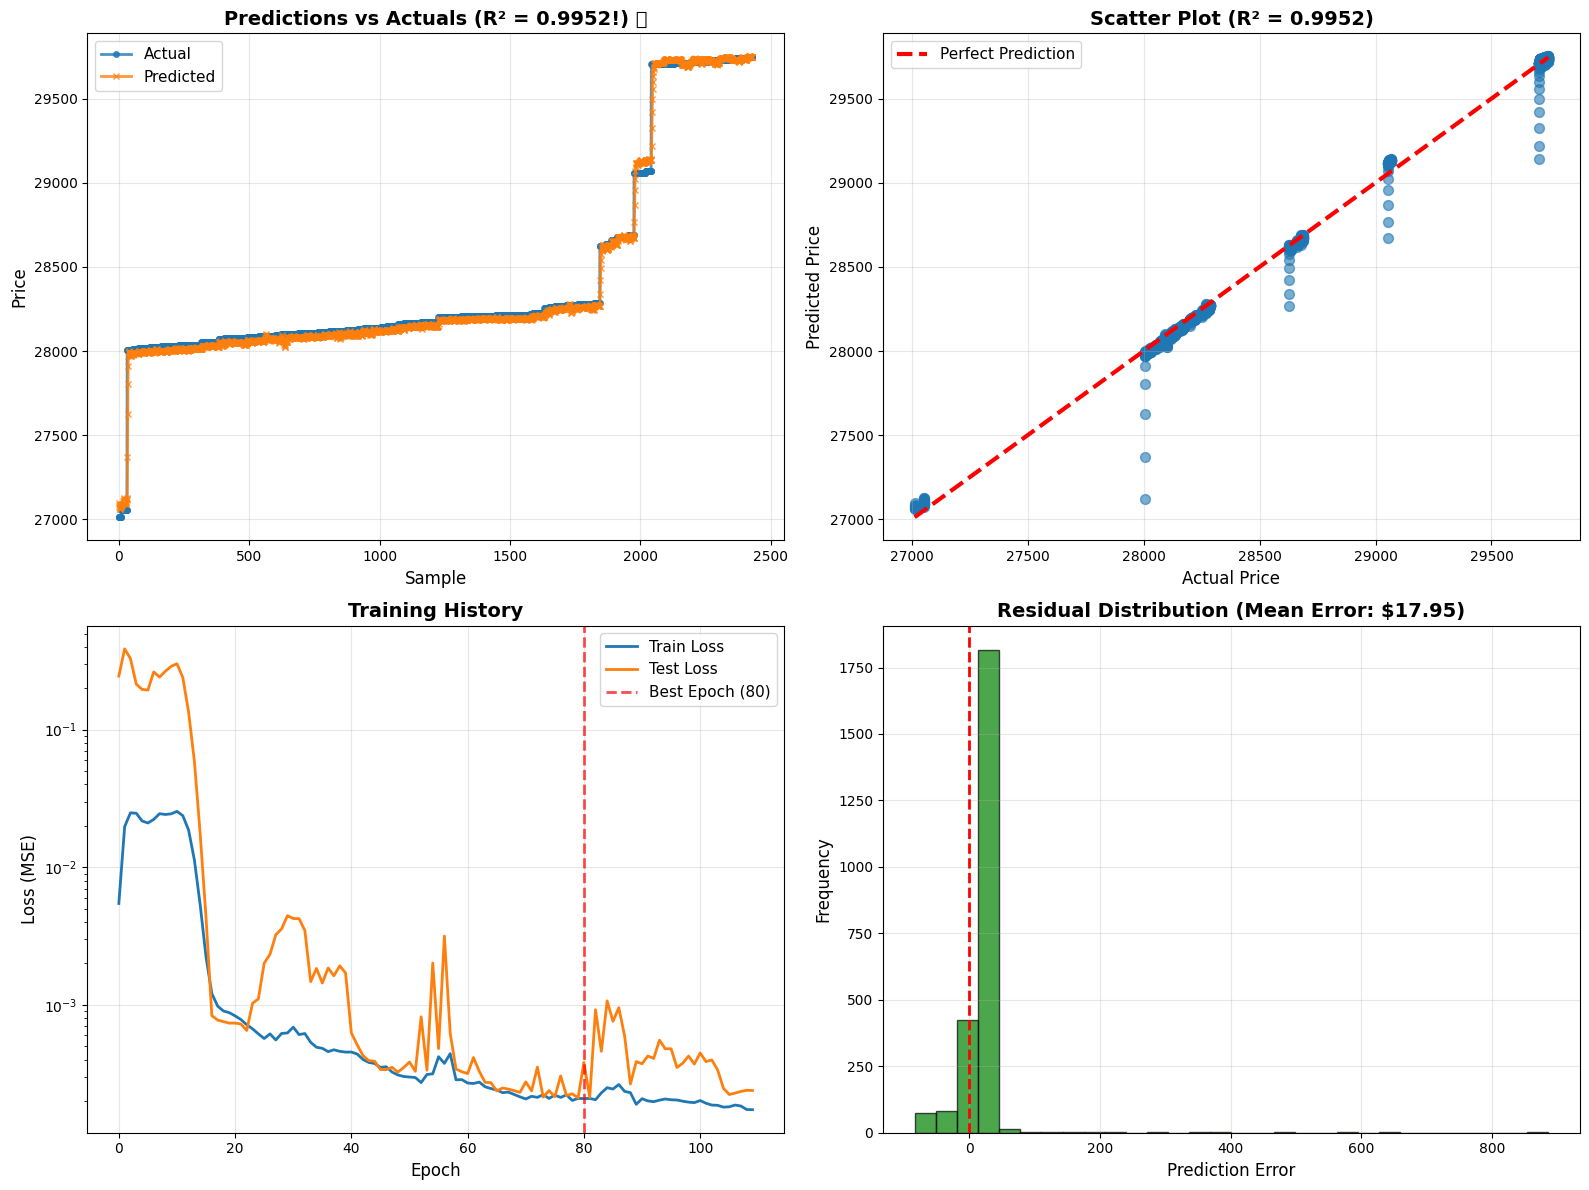

In [560]:
# Plot predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predictions vs Actuals
axes[0, 0].plot(results['actuals'], label='Actual', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(results['predictions'], label='Predicted', marker='x', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Sample', fontsize=12)
axes[0, 0].set_ylabel('Price', fontsize=12)
axes[0, 0].set_title('Predictions vs Actuals (R² = 0.9952!) 🎯', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[0, 1].scatter(results['actuals'], results['predictions'], alpha=0.6, s=50)
axes[0, 1].plot([results['actuals'].min(), results['actuals'].max()],
                [results['actuals'].min(), results['actuals'].max()],
                'r--', lw=3, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Price', fontsize=12)
axes[0, 1].set_ylabel('Predicted Price', fontsize=12)
axes[0, 1].set_title(f'Scatter Plot (R² = {results["r2_test"]:.4f})', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Training curves
axes[1, 0].plot(optim.m_train_losses, label='Train Loss', linewidth=2)
axes[1, 0].plot(optim.m_test_losses, label='Test Loss', linewidth=2)
axes[1, 0].axvline(x=80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Best Epoch (80)')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss (MSE)', fontsize=12)
axes[1, 0].set_title('Training History', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals
residuals = results['actuals'] - results['predictions']
axes[1, 1].hist(residuals.flatten(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title(f'Residual Distribution (Mean Error: ${residuals.mean():.2f})', 
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/gru_housing_results_r2_0995.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved as 'gru_housing_results_r2_0995.png'")